# Soft Attention MNIST

This is jupyter notebook for `Soft Attention` from paper [Show, Attend and Tell](https://arxiv.org/abs/1502.03044). 
<br>This Algorithm will be tested by `Modified MNIST dataset` Which is made by [Jongwon Park](https://github.com/jwpark116). <br>This modified MNIST dataset is good for verifying attention algorithm.
<br>You can download modified MNIST data from this link
<br>[Training dataset](https://www.dropbox.com/s/e7jxyulxx2anqyq/MNIST_data_train_re.mat?dl=0)  /  [Testing dataset](https://www.dropbox.com/s/fcw4754bavva9my/MNIST_data_test_re.mat?dl=0)

# TENSORFLOW 1

In [1]:
# Import modules
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import random
import skimage.transform
import cv2
import os

/home/jenazads/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jenazads/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jenazads/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jenazads/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [2]:
print(tf.version.VERSION)

1.14.0


In [3]:
print(tf.test.is_gpu_available())

False


In [4]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
((train_x, train_y), (test_x, test_y)) = mnist.load_data()

train_x = train_x.astype("float32") / 255.0
test_x = test_x.astype("float32") / 255.0

train_y = to_categorical(train_y, 10)
test_y = to_categorical(test_y, 10)

print(train_x.shape, train_y.shape)
train_x = np.expand_dims(train_x, axis=3)
test_x = np.expand_dims(test_x, axis=3)
print(train_x.shape, train_y.shape)

print("Train data shape: " + str(train_x.shape))
print("Train label shape: " + str(train_y.shape))
print("Test data shape: " + str(test_x.shape))
print("Test label shape: " + str(test_y.shape))
print(np.max(test_x), np.min(test_x))

(60000, 28, 28) (60000, 10)
(60000, 28, 28, 1) (60000, 10)
Train data shape: (60000, 28, 28, 1)
Train label shape: (60000, 10)
Test data shape: (10000, 28, 28, 1)
Test label shape: (10000, 10)
1.0 0.0


## Parameters

In [5]:
# Parameters 
img_size = train_x.shape[1]
img_flat_size = img_size * img_size

# If you want to train the model -> True, otherwise -> False
Is_train = True

# If you want to load saved model -> True, otherwise -> False 
Load_model = False

# Name of the save file
save_path = 'saved_models/soft/'
if not os.path.exists(save_path):
  os.makedirs(save_path)

# Numbers of sampling to test the code 
num_test_sample = 50

# labels: 0 - 9
num_label = 10

# Parameters for training
num_epoch = 10

learning_rate = 5e-4
epsilon = 1e-8

batch_size = 256

# Parameter for LSTM
lstm_size = 256
step_size = 4
flatten_size = img_size

gpu_fraction = 0.3

## Plotting Sample Image (Modified MNIST for Attention)

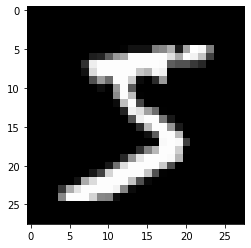

Label: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Shape: 28x28


In [6]:
# Plotting example image
img = train_x[0, :, :]

plt.imshow(img, cmap = 'gray')
plt.show()
print('Label: ' + str(train_y[0,:]))
print('Shape: ' + str(img_size) + 'x' + str(img_size))

## Functions for Convolutional Network

In [7]:
# Initialize weights and bias 
def conv2d(x,w, stride):
	return tf.nn.conv2d(x,w,strides=[1, stride, stride, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

# Get Variables
def weight_variable(name, shape):
    return tf.get_variable(name,shape=shape, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(name, shape):
    return tf.get_variable(name,shape=shape, initializer=tf.contrib.layers.xavier_initializer())

## LSTM and Attention function

In [8]:
# Reset the graph
tf.reset_default_graph()

# LSTM function
def LSTM_cell(C_prev, h_prev, x_lstm, Wf, Wi, Wc, Wo, bf, bi, bc, bo):
    # C_prev: Cell state from lstm of previous time step (shape: [batch_size, lstm_size])
    # h_prev: output from lstm of previous time step (shape: [batch_size, lstm_size])
    # x_lstm: input of lstm (shape: [batch_size, data_flatten_size])

    input_concat = tf.concat([x_lstm, h_prev], 1)
    f = tf.sigmoid(tf.matmul(input_concat, Wf) + bf)
    i = tf.sigmoid(tf.matmul(input_concat, Wi) + bi)
    c = tf.tanh(tf.matmul(input_concat, Wc) + bc)
    o = tf.sigmoid(tf.matmul(input_concat, Wo) + bo)
    
    C_t = tf.multiply(f, C_prev) + tf.multiply(i, c) 
    h_t = tf.multiply(o, tf.tanh(C_t))
    
    return C_t, h_t # Cell state, Output

# Soft Attention function
def soft_attention(h_prev, a, Wa, Wh):
    # h_prev: output from lstm of previous time step (shape: [batch_size, lstm_size])
    # a: Result of CNN [batch_size, conv_size * conv_size, channel_size] 

    m_list = [tf.tanh(tf.matmul(a[i], Wa) + tf.matmul(h_prev, Wh)) for i in range(len(a))] 
    m_concat = tf.concat([m_list[i] for i in range(len(a))], axis = 1)     
    alpha = tf.nn.softmax(m_concat) 
    z_list = [tf.multiply(a[i], tf.slice(alpha, (0, i), (-1, 1))) for i in range(len(a))]
    z_stack = tf.stack(z_list, axis = 2)
    z = tf.reduce_sum(z_stack, axis = 2)

    return alpha, z
    

## Network

In [9]:
# Network

# Input 
x_image  = tf.placeholder(tf.float32, shape = [None, img_size, img_size, 1])
y_target = tf.placeholder(tf.float32, shape=[None, num_label])

# Convolution variables
w_conv1 = weight_variable('W_conv1', [3, 3, 1, 64])
b_conv1 = bias_variable('b_conv1', [64])
w_conv2 = weight_variable('W_conv2', [3, 3, 64, 256])
b_conv2 = bias_variable('b_conv2', [256])
w_conv3 = weight_variable('W_conv3', [3, 3, 256, 512])
b_conv3 = bias_variable('b_conv3', [512])

conv1 = tf.nn.relu(conv2d(x_image, w_conv1, 2) + b_conv1)
conv2 = tf.nn.relu(conv2d(conv1, w_conv2, 2) + b_conv2)
conv3 = tf.nn.relu(conv2d(conv2, w_conv3, 2) + b_conv3)

conv_size = conv3.get_shape()[1]
conv_flat = tf.reshape(conv3, [-1, conv_size*conv_size, 512])
conv_unstack = tf.unstack(conv_flat, axis = 1)

#LSTM Variables
Wf = weight_variable('Wf', [512 + lstm_size, lstm_size])
Wi = weight_variable('Wi', [512 + lstm_size, lstm_size])
Wc = weight_variable('Wc', [512 + lstm_size, lstm_size])
Wo = weight_variable('Wo', [512 + lstm_size, lstm_size])

bf = bias_variable('bf', [lstm_size])
bi = bias_variable('bi', [lstm_size])
bc = bias_variable('bc', [lstm_size])
bo = bias_variable('bo', [lstm_size]) 

# Attention Variables
Wa = weight_variable('Wa', [512, 1])
Wh = weight_variable('Wh', [lstm_size, 1])

rnn_batch_size = tf.shape(x_image)[0]

# Initial lstm cell state and output 
rnn_state = tf.zeros([rnn_batch_size, lstm_size], tf.float32)
rnn_out = tf.zeros([rnn_batch_size, lstm_size], tf.float32)

#################################### Attention!!! ####################################
for i in range(step_size):
    alpha, z = soft_attention(rnn_out, conv_unstack, Wa, Wh)
    rnn_state, rnn_out = LSTM_cell(rnn_state, rnn_out, z, Wf, Wi, Wc, Wo, bf, bi, bc, bo)

######################################################################################

# Densely connect layer variables 
w_fc1 = weight_variable('w_fc1', [lstm_size, num_label])
b_fc1 = bias_variable('b_fc1', [num_label])

output = tf.matmul(rnn_out, w_fc1)+b_fc1


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [10]:
# Training 
Loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = y_target, logits = output)
Cost = tf.reduce_mean(Loss)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, epsilon = epsilon).minimize(Cost)

correct_prediction = tf.equal(tf.argmax(y_target,1), tf.argmax(output,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Create Session

In [11]:
# Create Session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = gpu_fraction

sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

## Save and Restore

In [12]:
# Load the file if the saved file exists
saver = tf.train.Saver()
if Load_model == True:
    checkpoint = tf.train.get_checkpoint_state(save_path)
    if checkpoint and checkpoint.model_checkpoint_path:
        saver.restore(sess, checkpoint.model_checkpoint_path)
        print("Successfully loaded:", checkpoint.model_checkpoint_path)
    else:
        print("Could not find old network weights")

## Training

In [13]:
# Training
interval_test=num_epoch/2
if Is_train == True:
    train_data_num = train_x.shape[0]
    test_data_num = test_x.shape[0]
    for i in range(num_epoch):
        # Making batches
        random_idx = np.arange(train_data_num)
        np.random.shuffle(random_idx)

        batch_count = 1
    
        for j in range(0, train_data_num, batch_size):
            if j + batch_size < train_data_num:
                batch_index = [j, j + batch_size]

                batch_x_train = train_x[random_idx[batch_index[0]:batch_index[1]],:,:]
                batch_y_train = train_y[random_idx[batch_index[0]:batch_index[1]],:]
            else:
                batch_index = [j, j + train_data_num-1]

                batch_x_train = train_x[random_idx[batch_index[0]:batch_index[-1]],:,:]
                batch_y_train = train_y[random_idx[batch_index[0]:batch_index[-1]],:]

            # Make image as fractions for attention
            train_batch = np.reshape(batch_x_train, (batch_x_train.shape[0], img_size, img_size, 1))
            #validation_batch = np.reshape(validation_x, (validation_x.shape[0], img_size, img_size, 1))
            
            # Training
            optimizer.run(feed_dict = {x_image: train_batch, y_target: batch_y_train})
            cost = sess.run(Cost, feed_dict = {x_image: train_batch, y_target: batch_y_train})
            acc = sess.run(accuracy, feed_dict = {x_image: train_batch, y_target: batch_y_train})
            #val_acc = sess.run(accuracy, feed_dict = {x_image: validation_batch, y_target: validation_y})

            # Print Progress
            print("Epoch: " + str(i+1) + ' / ' + 
                  "Batch: " + str(j) + '/' + str(train_data_num) + ' / ' + 
                  "Cost: " + str(cost) + ' / ' + 
                  "Training Accuracy: " + str(acc))# + ' / ' + 
#                   "Validation Accuracy: " + str(val_acc))  

        if (i+1)%interval_test==0:
            num_correct = 0
            saver.save(sess, save_path + "soft_attention")
            print('Model is saved!!!')

            print('Testing ...')
            idx = random.sample(range(test_x.shape[0]), test_data_num)
            for idx_sample in range(test_data_num):
                test_x_reshape = np.reshape(test_x, ([test_x.shape[0],img_size,img_size,1]))
                test_x_in = test_x_reshape[idx[idx_sample],:,:,:]
                output_ = sess.run(output,feed_dict = {x_image: [test_x_in], y_target: [test_y[idx[idx_sample],:]]})
                
                y_test_pred = np.argmax(output_[:])
                y_test_true = np.argmax(test_y[idx[idx_sample], :])
                if y_test_pred == y_test_true:
                    num_correct += 1.
                
            # Print Progress
            print("Testing Accuracy: " + str(num_correct/test_data_num))# + ' / ' + )

Epoch: 1 / Batch: 0/60000 / Cost: 0.6692059 / Training Accuracy: 0.09765625
Epoch: 1 / Batch: 256/60000 / Cost: 0.6228124 / Training Accuracy: 0.12109375
Epoch: 1 / Batch: 512/60000 / Cost: 0.56700367 / Training Accuracy: 0.10546875
Epoch: 1 / Batch: 768/60000 / Cost: 0.49345812 / Training Accuracy: 0.08984375
Epoch: 1 / Batch: 1024/60000 / Cost: 0.4142328 / Training Accuracy: 0.09375
Epoch: 1 / Batch: 1280/60000 / Cost: 0.35226926 / Training Accuracy: 0.078125
Epoch: 1 / Batch: 1536/60000 / Cost: 0.32635838 / Training Accuracy: 0.1015625
Epoch: 1 / Batch: 1792/60000 / Cost: 0.3395757 / Training Accuracy: 0.1015625
Epoch: 1 / Batch: 2048/60000 / Cost: 0.34931663 / Training Accuracy: 0.07421875
Epoch: 1 / Batch: 2304/60000 / Cost: 0.355576 / Training Accuracy: 0.09375
Epoch: 1 / Batch: 2560/60000 / Cost: 0.34776503 / Training Accuracy: 0.140625
Epoch: 1 / Batch: 2816/60000 / Cost: 0.3435515 / Training Accuracy: 0.15625
Epoch: 1 / Batch: 3072/60000 / Cost: 0.336821 / Training Accuracy: 0

Epoch: 1 / Batch: 26624/60000 / Cost: 0.30323714 / Training Accuracy: 0.25390625
Epoch: 1 / Batch: 26880/60000 / Cost: 0.30861825 / Training Accuracy: 0.2421875
Epoch: 1 / Batch: 27136/60000 / Cost: 0.29958087 / Training Accuracy: 0.28515625
Epoch: 1 / Batch: 27392/60000 / Cost: 0.3119238 / Training Accuracy: 0.18359375
Epoch: 1 / Batch: 27648/60000 / Cost: 0.3033896 / Training Accuracy: 0.24609375
Epoch: 1 / Batch: 27904/60000 / Cost: 0.2959296 / Training Accuracy: 0.2578125
Epoch: 1 / Batch: 28160/60000 / Cost: 0.30522913 / Training Accuracy: 0.203125
Epoch: 1 / Batch: 28416/60000 / Cost: 0.30473563 / Training Accuracy: 0.25390625
Epoch: 1 / Batch: 28672/60000 / Cost: 0.30069953 / Training Accuracy: 0.2578125
Epoch: 1 / Batch: 28928/60000 / Cost: 0.2997109 / Training Accuracy: 0.29296875
Epoch: 1 / Batch: 29184/60000 / Cost: 0.29708707 / Training Accuracy: 0.28515625
Epoch: 1 / Batch: 29440/60000 / Cost: 0.30389094 / Training Accuracy: 0.2734375
Epoch: 1 / Batch: 29696/60000 / Cost: 

Epoch: 1 / Batch: 52992/60000 / Cost: 0.18754566 / Training Accuracy: 0.6328125
Epoch: 1 / Batch: 53248/60000 / Cost: 0.18479852 / Training Accuracy: 0.66015625
Epoch: 1 / Batch: 53504/60000 / Cost: 0.18578568 / Training Accuracy: 0.640625
Epoch: 1 / Batch: 53760/60000 / Cost: 0.18753523 / Training Accuracy: 0.5859375
Epoch: 1 / Batch: 54016/60000 / Cost: 0.17009327 / Training Accuracy: 0.65625
Epoch: 1 / Batch: 54272/60000 / Cost: 0.16598132 / Training Accuracy: 0.6796875
Epoch: 1 / Batch: 54528/60000 / Cost: 0.17225063 / Training Accuracy: 0.7109375
Epoch: 1 / Batch: 54784/60000 / Cost: 0.17930946 / Training Accuracy: 0.68359375
Epoch: 1 / Batch: 55040/60000 / Cost: 0.16189845 / Training Accuracy: 0.66796875
Epoch: 1 / Batch: 55296/60000 / Cost: 0.17358442 / Training Accuracy: 0.6484375
Epoch: 1 / Batch: 55552/60000 / Cost: 0.16003543 / Training Accuracy: 0.6640625
Epoch: 1 / Batch: 55808/60000 / Cost: 0.15532038 / Training Accuracy: 0.7109375
Epoch: 1 / Batch: 56064/60000 / Cost: 0.

Epoch: 2 / Batch: 19200/60000 / Cost: 0.06163785 / Training Accuracy: 0.90234375
Epoch: 2 / Batch: 19456/60000 / Cost: 0.07490735 / Training Accuracy: 0.890625
Epoch: 2 / Batch: 19712/60000 / Cost: 0.06759486 / Training Accuracy: 0.92578125
Epoch: 2 / Batch: 19968/60000 / Cost: 0.061541595 / Training Accuracy: 0.9140625
Epoch: 2 / Batch: 20224/60000 / Cost: 0.06964572 / Training Accuracy: 0.890625
Epoch: 2 / Batch: 20480/60000 / Cost: 0.07103898 / Training Accuracy: 0.8984375
Epoch: 2 / Batch: 20736/60000 / Cost: 0.064423434 / Training Accuracy: 0.9296875
Epoch: 2 / Batch: 20992/60000 / Cost: 0.07005857 / Training Accuracy: 0.88671875
Epoch: 2 / Batch: 21248/60000 / Cost: 0.0751165 / Training Accuracy: 0.87890625
Epoch: 2 / Batch: 21504/60000 / Cost: 0.06381349 / Training Accuracy: 0.91015625
Epoch: 2 / Batch: 21760/60000 / Cost: 0.06274581 / Training Accuracy: 0.91796875
Epoch: 2 / Batch: 22016/60000 / Cost: 0.060957216 / Training Accuracy: 0.921875
Epoch: 2 / Batch: 22272/60000 / Cos

Epoch: 2 / Batch: 45312/60000 / Cost: 0.046271257 / Training Accuracy: 0.9375
Epoch: 2 / Batch: 45568/60000 / Cost: 0.043096785 / Training Accuracy: 0.9453125
Epoch: 2 / Batch: 45824/60000 / Cost: 0.04177115 / Training Accuracy: 0.9453125
Epoch: 2 / Batch: 46080/60000 / Cost: 0.04831045 / Training Accuracy: 0.9296875
Epoch: 2 / Batch: 46336/60000 / Cost: 0.048718236 / Training Accuracy: 0.9140625
Epoch: 2 / Batch: 46592/60000 / Cost: 0.028968047 / Training Accuracy: 0.97265625
Epoch: 2 / Batch: 46848/60000 / Cost: 0.042466182 / Training Accuracy: 0.9375
Epoch: 2 / Batch: 47104/60000 / Cost: 0.04102444 / Training Accuracy: 0.92578125
Epoch: 2 / Batch: 47360/60000 / Cost: 0.044859402 / Training Accuracy: 0.94140625
Epoch: 2 / Batch: 47616/60000 / Cost: 0.037035406 / Training Accuracy: 0.94921875
Epoch: 2 / Batch: 47872/60000 / Cost: 0.04782597 / Training Accuracy: 0.921875
Epoch: 2 / Batch: 48128/60000 / Cost: 0.05040173 / Training Accuracy: 0.921875
Epoch: 2 / Batch: 48384/60000 / Cost:

Epoch: 3 / Batch: 11520/60000 / Cost: 0.035916775 / Training Accuracy: 0.9453125
Epoch: 3 / Batch: 11776/60000 / Cost: 0.038518835 / Training Accuracy: 0.94921875
Epoch: 3 / Batch: 12032/60000 / Cost: 0.028179264 / Training Accuracy: 0.953125
Epoch: 3 / Batch: 12288/60000 / Cost: 0.036201634 / Training Accuracy: 0.953125
Epoch: 3 / Batch: 12544/60000 / Cost: 0.04647838 / Training Accuracy: 0.9375
Epoch: 3 / Batch: 12800/60000 / Cost: 0.030876562 / Training Accuracy: 0.95703125
Epoch: 3 / Batch: 13056/60000 / Cost: 0.03964643 / Training Accuracy: 0.92578125
Epoch: 3 / Batch: 13312/60000 / Cost: 0.043854076 / Training Accuracy: 0.9296875
Epoch: 3 / Batch: 13568/60000 / Cost: 0.029880982 / Training Accuracy: 0.953125
Epoch: 3 / Batch: 13824/60000 / Cost: 0.030936608 / Training Accuracy: 0.95703125
Epoch: 3 / Batch: 14080/60000 / Cost: 0.031107765 / Training Accuracy: 0.953125
Epoch: 3 / Batch: 14336/60000 / Cost: 0.027794922 / Training Accuracy: 0.9609375
Epoch: 3 / Batch: 14592/60000 / C

Epoch: 3 / Batch: 37632/60000 / Cost: 0.029367018 / Training Accuracy: 0.9453125
Epoch: 3 / Batch: 37888/60000 / Cost: 0.02133038 / Training Accuracy: 0.9765625
Epoch: 3 / Batch: 38144/60000 / Cost: 0.024954762 / Training Accuracy: 0.95703125
Epoch: 3 / Batch: 38400/60000 / Cost: 0.044433847 / Training Accuracy: 0.921875
Epoch: 3 / Batch: 38656/60000 / Cost: 0.037412725 / Training Accuracy: 0.94921875
Epoch: 3 / Batch: 38912/60000 / Cost: 0.03137009 / Training Accuracy: 0.94140625
Epoch: 3 / Batch: 39168/60000 / Cost: 0.031856738 / Training Accuracy: 0.953125
Epoch: 3 / Batch: 39424/60000 / Cost: 0.019431187 / Training Accuracy: 0.9765625
Epoch: 3 / Batch: 39680/60000 / Cost: 0.028121028 / Training Accuracy: 0.96484375
Epoch: 3 / Batch: 39936/60000 / Cost: 0.027117196 / Training Accuracy: 0.9609375
Epoch: 3 / Batch: 40192/60000 / Cost: 0.029946 / Training Accuracy: 0.9609375
Epoch: 3 / Batch: 40448/60000 / Cost: 0.020973817 / Training Accuracy: 0.97265625
Epoch: 3 / Batch: 40704/60000 

Epoch: 4 / Batch: 3584/60000 / Cost: 0.033384524 / Training Accuracy: 0.94921875
Epoch: 4 / Batch: 3840/60000 / Cost: 0.027630191 / Training Accuracy: 0.94140625
Epoch: 4 / Batch: 4096/60000 / Cost: 0.021058679 / Training Accuracy: 0.96875
Epoch: 4 / Batch: 4352/60000 / Cost: 0.017125404 / Training Accuracy: 0.97265625
Epoch: 4 / Batch: 4608/60000 / Cost: 0.02522623 / Training Accuracy: 0.953125
Epoch: 4 / Batch: 4864/60000 / Cost: 0.030006802 / Training Accuracy: 0.953125
Epoch: 4 / Batch: 5120/60000 / Cost: 0.028411472 / Training Accuracy: 0.95703125
Epoch: 4 / Batch: 5376/60000 / Cost: 0.02375339 / Training Accuracy: 0.94921875
Epoch: 4 / Batch: 5632/60000 / Cost: 0.017414663 / Training Accuracy: 0.98828125
Epoch: 4 / Batch: 5888/60000 / Cost: 0.023190325 / Training Accuracy: 0.953125
Epoch: 4 / Batch: 6144/60000 / Cost: 0.017780457 / Training Accuracy: 0.97265625
Epoch: 4 / Batch: 6400/60000 / Cost: 0.028362745 / Training Accuracy: 0.953125
Epoch: 4 / Batch: 6656/60000 / Cost: 0.01

Epoch: 4 / Batch: 29696/60000 / Cost: 0.021732595 / Training Accuracy: 0.96484375
Epoch: 4 / Batch: 29952/60000 / Cost: 0.02684317 / Training Accuracy: 0.96484375
Epoch: 4 / Batch: 30208/60000 / Cost: 0.02085029 / Training Accuracy: 0.96875
Epoch: 4 / Batch: 30464/60000 / Cost: 0.025109444 / Training Accuracy: 0.97265625
Epoch: 4 / Batch: 30720/60000 / Cost: 0.023128456 / Training Accuracy: 0.96875
Epoch: 4 / Batch: 30976/60000 / Cost: 0.021518335 / Training Accuracy: 0.97265625
Epoch: 4 / Batch: 31232/60000 / Cost: 0.022449993 / Training Accuracy: 0.96875
Epoch: 4 / Batch: 31488/60000 / Cost: 0.023776019 / Training Accuracy: 0.96484375
Epoch: 4 / Batch: 31744/60000 / Cost: 0.016497312 / Training Accuracy: 0.9765625
Epoch: 4 / Batch: 32000/60000 / Cost: 0.02142781 / Training Accuracy: 0.95703125
Epoch: 4 / Batch: 32256/60000 / Cost: 0.030501053 / Training Accuracy: 0.94140625
Epoch: 4 / Batch: 32512/60000 / Cost: 0.02588866 / Training Accuracy: 0.96484375
Epoch: 4 / Batch: 32768/60000 

Epoch: 4 / Batch: 55808/60000 / Cost: 0.020982532 / Training Accuracy: 0.9609375
Epoch: 4 / Batch: 56064/60000 / Cost: 0.02653497 / Training Accuracy: 0.96875
Epoch: 4 / Batch: 56320/60000 / Cost: 0.020212268 / Training Accuracy: 0.96484375
Epoch: 4 / Batch: 56576/60000 / Cost: 0.016924948 / Training Accuracy: 0.96875
Epoch: 4 / Batch: 56832/60000 / Cost: 0.016470965 / Training Accuracy: 0.9765625
Epoch: 4 / Batch: 57088/60000 / Cost: 0.021590576 / Training Accuracy: 0.96875
Epoch: 4 / Batch: 57344/60000 / Cost: 0.022468198 / Training Accuracy: 0.9609375
Epoch: 4 / Batch: 57600/60000 / Cost: 0.01823454 / Training Accuracy: 0.9765625
Epoch: 4 / Batch: 57856/60000 / Cost: 0.022826146 / Training Accuracy: 0.96484375
Epoch: 4 / Batch: 58112/60000 / Cost: 0.01637056 / Training Accuracy: 0.97265625
Epoch: 4 / Batch: 58368/60000 / Cost: 0.014702573 / Training Accuracy: 0.984375
Epoch: 4 / Batch: 58624/60000 / Cost: 0.020555105 / Training Accuracy: 0.96875
Epoch: 4 / Batch: 58880/60000 / Cost:

Epoch: 5 / Batch: 21760/60000 / Cost: 0.02877872 / Training Accuracy: 0.95703125
Epoch: 5 / Batch: 22016/60000 / Cost: 0.015700836 / Training Accuracy: 0.97265625
Epoch: 5 / Batch: 22272/60000 / Cost: 0.011540544 / Training Accuracy: 0.98828125
Epoch: 5 / Batch: 22528/60000 / Cost: 0.024442498 / Training Accuracy: 0.96484375
Epoch: 5 / Batch: 22784/60000 / Cost: 0.017701298 / Training Accuracy: 0.9765625
Epoch: 5 / Batch: 23040/60000 / Cost: 0.016513025 / Training Accuracy: 0.97265625
Epoch: 5 / Batch: 23296/60000 / Cost: 0.019042622 / Training Accuracy: 0.97265625
Epoch: 5 / Batch: 23552/60000 / Cost: 0.020249898 / Training Accuracy: 0.9609375
Epoch: 5 / Batch: 23808/60000 / Cost: 0.012506485 / Training Accuracy: 0.984375
Epoch: 5 / Batch: 24064/60000 / Cost: 0.019906541 / Training Accuracy: 0.95703125
Epoch: 5 / Batch: 24320/60000 / Cost: 0.011903077 / Training Accuracy: 0.98828125
Epoch: 5 / Batch: 24576/60000 / Cost: 0.02176327 / Training Accuracy: 0.97265625
Epoch: 5 / Batch: 2483

Epoch: 5 / Batch: 47616/60000 / Cost: 0.01472078 / Training Accuracy: 0.98046875
Epoch: 5 / Batch: 47872/60000 / Cost: 0.019720009 / Training Accuracy: 0.96484375
Epoch: 5 / Batch: 48128/60000 / Cost: 0.015136877 / Training Accuracy: 0.9765625
Epoch: 5 / Batch: 48384/60000 / Cost: 0.02257392 / Training Accuracy: 0.9609375
Epoch: 5 / Batch: 48640/60000 / Cost: 0.020874955 / Training Accuracy: 0.96484375
Epoch: 5 / Batch: 48896/60000 / Cost: 0.017087096 / Training Accuracy: 0.9765625
Epoch: 5 / Batch: 49152/60000 / Cost: 0.011346558 / Training Accuracy: 0.9765625
Epoch: 5 / Batch: 49408/60000 / Cost: 0.020338297 / Training Accuracy: 0.9609375
Epoch: 5 / Batch: 49664/60000 / Cost: 0.0102259815 / Training Accuracy: 0.9921875
Epoch: 5 / Batch: 49920/60000 / Cost: 0.009903506 / Training Accuracy: 0.9921875
Epoch: 5 / Batch: 50176/60000 / Cost: 0.008063903 / Training Accuracy: 0.9921875
Epoch: 5 / Batch: 50432/60000 / Cost: 0.015314868 / Training Accuracy: 0.98046875
Epoch: 5 / Batch: 50688/6

Epoch: 6 / Batch: 13312/60000 / Cost: 0.010740614 / Training Accuracy: 0.98828125
Epoch: 6 / Batch: 13568/60000 / Cost: 0.012505243 / Training Accuracy: 0.9765625
Epoch: 6 / Batch: 13824/60000 / Cost: 0.022358868 / Training Accuracy: 0.9609375
Epoch: 6 / Batch: 14080/60000 / Cost: 0.009448102 / Training Accuracy: 0.984375
Epoch: 6 / Batch: 14336/60000 / Cost: 0.011663026 / Training Accuracy: 0.98828125
Epoch: 6 / Batch: 14592/60000 / Cost: 0.0077905483 / Training Accuracy: 0.98828125
Epoch: 6 / Batch: 14848/60000 / Cost: 0.005552945 / Training Accuracy: 0.99609375
Epoch: 6 / Batch: 15104/60000 / Cost: 0.009951679 / Training Accuracy: 0.9921875
Epoch: 6 / Batch: 15360/60000 / Cost: 0.006764007 / Training Accuracy: 0.9921875
Epoch: 6 / Batch: 15616/60000 / Cost: 0.007336661 / Training Accuracy: 0.9921875
Epoch: 6 / Batch: 15872/60000 / Cost: 0.014782747 / Training Accuracy: 0.9765625
Epoch: 6 / Batch: 16128/60000 / Cost: 0.009856759 / Training Accuracy: 0.984375
Epoch: 6 / Batch: 16384/6

Epoch: 6 / Batch: 39424/60000 / Cost: 0.015075457 / Training Accuracy: 0.9765625
Epoch: 6 / Batch: 39680/60000 / Cost: 0.0070914156 / Training Accuracy: 0.9921875
Epoch: 6 / Batch: 39936/60000 / Cost: 0.012747904 / Training Accuracy: 0.98046875
Epoch: 6 / Batch: 40192/60000 / Cost: 0.012341035 / Training Accuracy: 0.9765625
Epoch: 6 / Batch: 40448/60000 / Cost: 0.010304876 / Training Accuracy: 0.98828125
Epoch: 6 / Batch: 40704/60000 / Cost: 0.011050083 / Training Accuracy: 0.9765625
Epoch: 6 / Batch: 40960/60000 / Cost: 0.008645838 / Training Accuracy: 0.9921875
Epoch: 6 / Batch: 41216/60000 / Cost: 0.01141033 / Training Accuracy: 0.98828125
Epoch: 6 / Batch: 41472/60000 / Cost: 0.0103537245 / Training Accuracy: 0.98828125
Epoch: 6 / Batch: 41728/60000 / Cost: 0.009023648 / Training Accuracy: 0.98828125
Epoch: 6 / Batch: 41984/60000 / Cost: 0.015353787 / Training Accuracy: 0.98046875
Epoch: 6 / Batch: 42240/60000 / Cost: 0.013783756 / Training Accuracy: 0.984375
Epoch: 6 / Batch: 4249

Epoch: 7 / Batch: 5376/60000 / Cost: 0.0063172923 / Training Accuracy: 0.9921875
Epoch: 7 / Batch: 5632/60000 / Cost: 0.0105564175 / Training Accuracy: 0.98828125
Epoch: 7 / Batch: 5888/60000 / Cost: 0.012954116 / Training Accuracy: 0.98046875
Epoch: 7 / Batch: 6144/60000 / Cost: 0.016463252 / Training Accuracy: 0.9765625
Epoch: 7 / Batch: 6400/60000 / Cost: 0.009558986 / Training Accuracy: 0.98828125
Epoch: 7 / Batch: 6656/60000 / Cost: 0.01416859 / Training Accuracy: 0.9765625
Epoch: 7 / Batch: 6912/60000 / Cost: 0.013783231 / Training Accuracy: 0.9765625
Epoch: 7 / Batch: 7168/60000 / Cost: 0.011438886 / Training Accuracy: 0.984375
Epoch: 7 / Batch: 7424/60000 / Cost: 0.005025639 / Training Accuracy: 0.99609375
Epoch: 7 / Batch: 7680/60000 / Cost: 0.0069113495 / Training Accuracy: 0.98828125
Epoch: 7 / Batch: 7936/60000 / Cost: 0.010886705 / Training Accuracy: 0.98046875
Epoch: 7 / Batch: 8192/60000 / Cost: 0.006790665 / Training Accuracy: 0.98828125
Epoch: 7 / Batch: 8448/60000 / C

Epoch: 7 / Batch: 31488/60000 / Cost: 0.01731656 / Training Accuracy: 0.97265625
Epoch: 7 / Batch: 31744/60000 / Cost: 0.006941366 / Training Accuracy: 0.984375
Epoch: 7 / Batch: 32000/60000 / Cost: 0.010487052 / Training Accuracy: 0.984375
Epoch: 7 / Batch: 32256/60000 / Cost: 0.018670252 / Training Accuracy: 0.9609375
Epoch: 7 / Batch: 32512/60000 / Cost: 0.012573848 / Training Accuracy: 0.984375
Epoch: 7 / Batch: 32768/60000 / Cost: 0.015743893 / Training Accuracy: 0.9765625
Epoch: 7 / Batch: 33024/60000 / Cost: 0.00687842 / Training Accuracy: 0.984375
Epoch: 7 / Batch: 33280/60000 / Cost: 0.010127777 / Training Accuracy: 0.9765625
Epoch: 7 / Batch: 33536/60000 / Cost: 0.020031027 / Training Accuracy: 0.97265625
Epoch: 7 / Batch: 33792/60000 / Cost: 0.016162846 / Training Accuracy: 0.98046875
Epoch: 7 / Batch: 34048/60000 / Cost: 0.009583226 / Training Accuracy: 0.9921875
Epoch: 7 / Batch: 34304/60000 / Cost: 0.020065656 / Training Accuracy: 0.96875
Epoch: 7 / Batch: 34560/60000 / C

Epoch: 7 / Batch: 57600/60000 / Cost: 0.0070547936 / Training Accuracy: 0.9921875
Epoch: 7 / Batch: 57856/60000 / Cost: 0.011338937 / Training Accuracy: 0.984375
Epoch: 7 / Batch: 58112/60000 / Cost: 0.008574249 / Training Accuracy: 0.98828125
Epoch: 7 / Batch: 58368/60000 / Cost: 0.009796066 / Training Accuracy: 0.984375
Epoch: 7 / Batch: 58624/60000 / Cost: 0.0048191138 / Training Accuracy: 1.0
Epoch: 7 / Batch: 58880/60000 / Cost: 0.012292325 / Training Accuracy: 0.98828125
Epoch: 7 / Batch: 59136/60000 / Cost: 0.00704583 / Training Accuracy: 0.9921875
Epoch: 7 / Batch: 59392/60000 / Cost: 0.0058288253 / Training Accuracy: 0.9921875
Epoch: 7 / Batch: 59648/60000 / Cost: 0.015133289 / Training Accuracy: 0.9765625
Epoch: 7 / Batch: 59904/60000 / Cost: 0.003592956 / Training Accuracy: 0.9895833
Epoch: 8 / Batch: 0/60000 / Cost: 0.009335281 / Training Accuracy: 0.98046875
Epoch: 8 / Batch: 256/60000 / Cost: 0.014026183 / Training Accuracy: 0.98046875
Epoch: 8 / Batch: 512/60000 / Cost: 

Epoch: 8 / Batch: 23552/60000 / Cost: 0.011567159 / Training Accuracy: 0.984375
Epoch: 8 / Batch: 23808/60000 / Cost: 0.0085615385 / Training Accuracy: 0.984375
Epoch: 8 / Batch: 24064/60000 / Cost: 0.010883015 / Training Accuracy: 0.984375
Epoch: 8 / Batch: 24320/60000 / Cost: 0.012896386 / Training Accuracy: 0.98046875
Epoch: 8 / Batch: 24576/60000 / Cost: 0.007871447 / Training Accuracy: 0.9921875
Epoch: 8 / Batch: 24832/60000 / Cost: 0.006291671 / Training Accuracy: 0.98828125
Epoch: 8 / Batch: 25088/60000 / Cost: 0.0147179635 / Training Accuracy: 0.98046875
Epoch: 8 / Batch: 25344/60000 / Cost: 0.006035842 / Training Accuracy: 0.984375
Epoch: 8 / Batch: 25600/60000 / Cost: 0.0050066165 / Training Accuracy: 0.99609375
Epoch: 8 / Batch: 25856/60000 / Cost: 0.0065948055 / Training Accuracy: 0.98828125
Epoch: 8 / Batch: 26112/60000 / Cost: 0.008002969 / Training Accuracy: 0.984375
Epoch: 8 / Batch: 26368/60000 / Cost: 0.007828225 / Training Accuracy: 0.98828125
Epoch: 8 / Batch: 26624

Epoch: 8 / Batch: 49408/60000 / Cost: 0.01750513 / Training Accuracy: 0.96875
Epoch: 8 / Batch: 49664/60000 / Cost: 0.009655123 / Training Accuracy: 0.98828125
Epoch: 8 / Batch: 49920/60000 / Cost: 0.009097876 / Training Accuracy: 0.984375
Epoch: 8 / Batch: 50176/60000 / Cost: 0.0064648623 / Training Accuracy: 0.99609375
Epoch: 8 / Batch: 50432/60000 / Cost: 0.008843766 / Training Accuracy: 0.98828125
Epoch: 8 / Batch: 50688/60000 / Cost: 0.0069065616 / Training Accuracy: 0.98828125
Epoch: 8 / Batch: 50944/60000 / Cost: 0.0036827722 / Training Accuracy: 1.0
Epoch: 8 / Batch: 51200/60000 / Cost: 0.014488948 / Training Accuracy: 0.98046875
Epoch: 8 / Batch: 51456/60000 / Cost: 0.01544981 / Training Accuracy: 0.96875
Epoch: 8 / Batch: 51712/60000 / Cost: 0.014405924 / Training Accuracy: 0.98046875
Epoch: 8 / Batch: 51968/60000 / Cost: 0.009805888 / Training Accuracy: 0.98828125
Epoch: 8 / Batch: 52224/60000 / Cost: 0.009071666 / Training Accuracy: 0.984375
Epoch: 8 / Batch: 52480/60000 / 

Epoch: 9 / Batch: 15360/60000 / Cost: 0.007127717 / Training Accuracy: 0.9921875
Epoch: 9 / Batch: 15616/60000 / Cost: 0.007933379 / Training Accuracy: 0.9921875
Epoch: 9 / Batch: 15872/60000 / Cost: 0.010129926 / Training Accuracy: 0.98828125
Epoch: 9 / Batch: 16128/60000 / Cost: 0.0041525303 / Training Accuracy: 0.9921875
Epoch: 9 / Batch: 16384/60000 / Cost: 0.0075479606 / Training Accuracy: 0.9921875
Epoch: 9 / Batch: 16640/60000 / Cost: 0.011383168 / Training Accuracy: 0.984375
Epoch: 9 / Batch: 16896/60000 / Cost: 0.011588814 / Training Accuracy: 0.984375
Epoch: 9 / Batch: 17152/60000 / Cost: 0.007953884 / Training Accuracy: 0.9921875
Epoch: 9 / Batch: 17408/60000 / Cost: 0.016511893 / Training Accuracy: 0.9765625
Epoch: 9 / Batch: 17664/60000 / Cost: 0.0039042481 / Training Accuracy: 1.0
Epoch: 9 / Batch: 17920/60000 / Cost: 0.009755665 / Training Accuracy: 0.984375
Epoch: 9 / Batch: 18176/60000 / Cost: 0.005787492 / Training Accuracy: 0.9921875
Epoch: 9 / Batch: 18432/60000 / C

Epoch: 9 / Batch: 41216/60000 / Cost: 0.008129253 / Training Accuracy: 0.98828125
Epoch: 9 / Batch: 41472/60000 / Cost: 0.007727301 / Training Accuracy: 0.9921875
Epoch: 9 / Batch: 41728/60000 / Cost: 0.014878415 / Training Accuracy: 0.98046875
Epoch: 9 / Batch: 41984/60000 / Cost: 0.0043808147 / Training Accuracy: 0.99609375
Epoch: 9 / Batch: 42240/60000 / Cost: 0.010202812 / Training Accuracy: 0.984375
Epoch: 9 / Batch: 42496/60000 / Cost: 0.011379431 / Training Accuracy: 0.98046875
Epoch: 9 / Batch: 42752/60000 / Cost: 0.009681036 / Training Accuracy: 0.98046875
Epoch: 9 / Batch: 43008/60000 / Cost: 0.008216208 / Training Accuracy: 0.9921875
Epoch: 9 / Batch: 43264/60000 / Cost: 0.0083419 / Training Accuracy: 0.9921875
Epoch: 9 / Batch: 43520/60000 / Cost: 0.004829933 / Training Accuracy: 0.99609375
Epoch: 9 / Batch: 43776/60000 / Cost: 0.0077534467 / Training Accuracy: 0.98828125
Epoch: 9 / Batch: 44032/60000 / Cost: 0.00477451 / Training Accuracy: 0.99609375
Epoch: 9 / Batch: 4428

Epoch: 10 / Batch: 6912/60000 / Cost: 0.0061910776 / Training Accuracy: 0.99609375
Epoch: 10 / Batch: 7168/60000 / Cost: 0.0036174275 / Training Accuracy: 0.99609375
Epoch: 10 / Batch: 7424/60000 / Cost: 0.0035840615 / Training Accuracy: 0.99609375
Epoch: 10 / Batch: 7680/60000 / Cost: 0.010529874 / Training Accuracy: 0.98046875
Epoch: 10 / Batch: 7936/60000 / Cost: 0.005706914 / Training Accuracy: 0.99609375
Epoch: 10 / Batch: 8192/60000 / Cost: 0.006359735 / Training Accuracy: 0.98828125
Epoch: 10 / Batch: 8448/60000 / Cost: 0.0074344887 / Training Accuracy: 0.9921875
Epoch: 10 / Batch: 8704/60000 / Cost: 0.007653174 / Training Accuracy: 0.98828125
Epoch: 10 / Batch: 8960/60000 / Cost: 0.007428153 / Training Accuracy: 0.98828125
Epoch: 10 / Batch: 9216/60000 / Cost: 0.0035015293 / Training Accuracy: 1.0
Epoch: 10 / Batch: 9472/60000 / Cost: 0.006421853 / Training Accuracy: 0.98046875
Epoch: 10 / Batch: 9728/60000 / Cost: 0.0036373292 / Training Accuracy: 0.99609375
Epoch: 10 / Batch:

Epoch: 10 / Batch: 32512/60000 / Cost: 0.005350233 / Training Accuracy: 0.9921875
Epoch: 10 / Batch: 32768/60000 / Cost: 0.0027266284 / Training Accuracy: 1.0
Epoch: 10 / Batch: 33024/60000 / Cost: 0.014765981 / Training Accuracy: 0.98046875
Epoch: 10 / Batch: 33280/60000 / Cost: 0.0038405266 / Training Accuracy: 0.99609375
Epoch: 10 / Batch: 33536/60000 / Cost: 0.0071245134 / Training Accuracy: 0.9921875
Epoch: 10 / Batch: 33792/60000 / Cost: 0.004153034 / Training Accuracy: 0.99609375
Epoch: 10 / Batch: 34048/60000 / Cost: 0.0072271256 / Training Accuracy: 0.9921875
Epoch: 10 / Batch: 34304/60000 / Cost: 0.0040151803 / Training Accuracy: 0.9921875
Epoch: 10 / Batch: 34560/60000 / Cost: 0.013172182 / Training Accuracy: 0.97265625
Epoch: 10 / Batch: 34816/60000 / Cost: 0.0062712096 / Training Accuracy: 0.9921875
Epoch: 10 / Batch: 35072/60000 / Cost: 0.0072508813 / Training Accuracy: 0.984375
Epoch: 10 / Batch: 35328/60000 / Cost: 0.0046782196 / Training Accuracy: 0.9921875
Epoch: 10 /

Epoch: 10 / Batch: 58112/60000 / Cost: 0.004631467 / Training Accuracy: 0.99609375
Epoch: 10 / Batch: 58368/60000 / Cost: 0.0027621305 / Training Accuracy: 0.99609375
Epoch: 10 / Batch: 58624/60000 / Cost: 0.011120411 / Training Accuracy: 0.984375
Epoch: 10 / Batch: 58880/60000 / Cost: 0.004126115 / Training Accuracy: 0.99609375
Epoch: 10 / Batch: 59136/60000 / Cost: 0.009094085 / Training Accuracy: 0.984375
Epoch: 10 / Batch: 59392/60000 / Cost: 0.004358662 / Training Accuracy: 0.99609375
Epoch: 10 / Batch: 59648/60000 / Cost: 0.0040367497 / Training Accuracy: 0.99609375
Epoch: 10 / Batch: 59904/60000 / Cost: 0.0016981814 / Training Accuracy: 1.0
Model is saved!!!
Testing ...
Testing Accuracy: 0.9809


## Testing

/home/jenazads/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


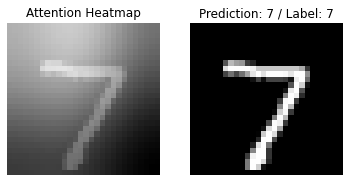

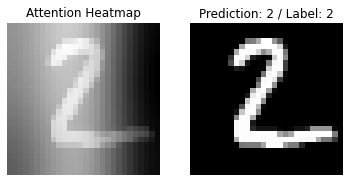

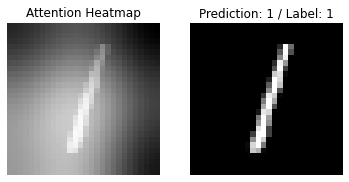

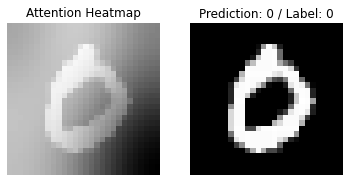

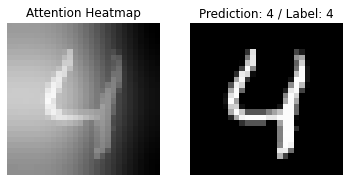

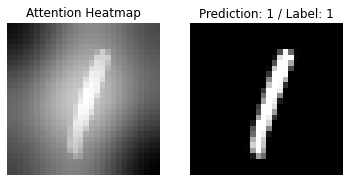

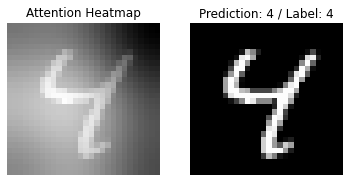

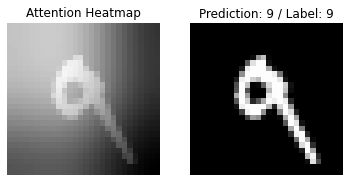

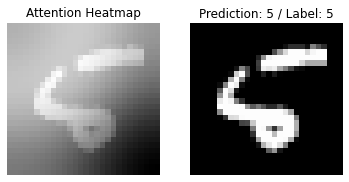

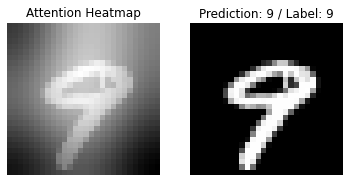

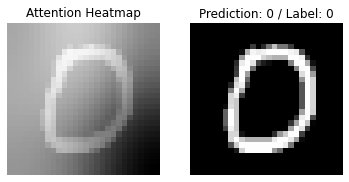

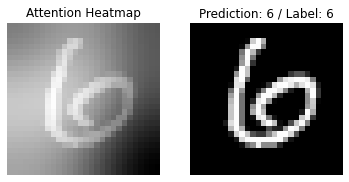

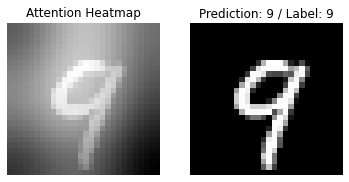

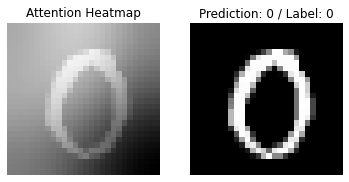

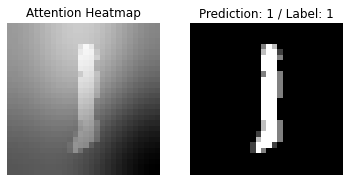

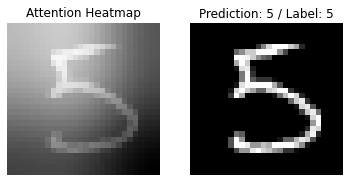

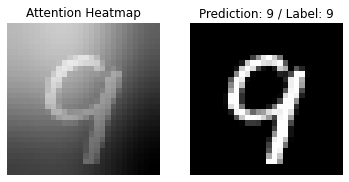

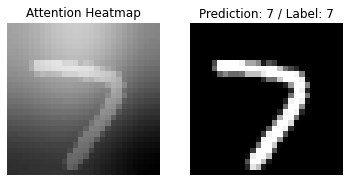

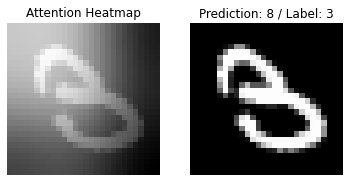

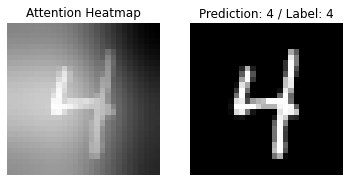

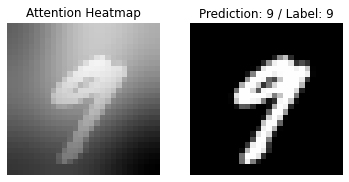

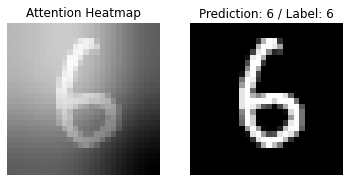

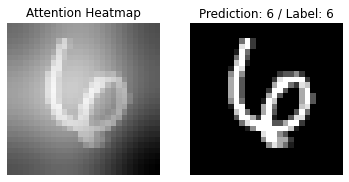

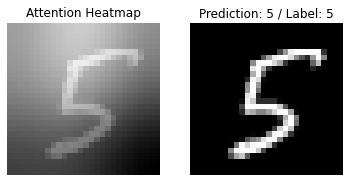

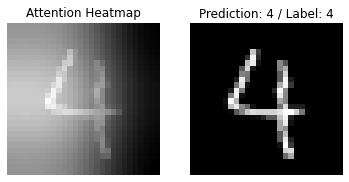

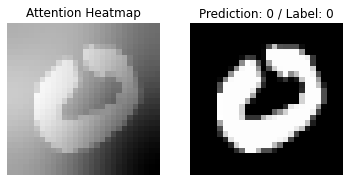

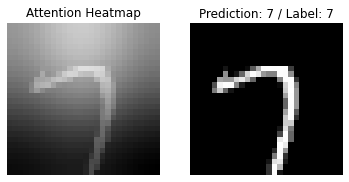

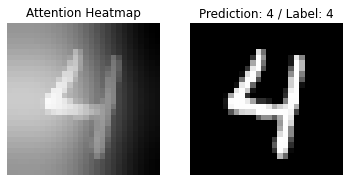

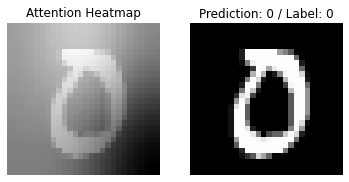

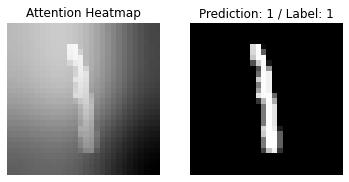

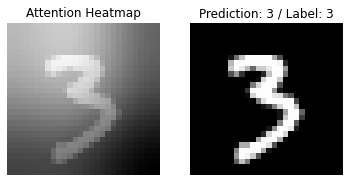

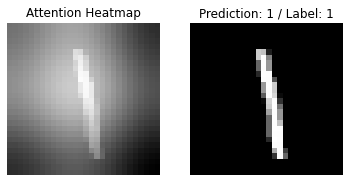

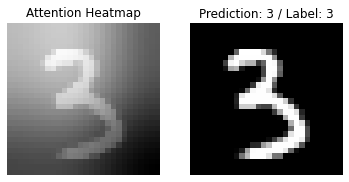

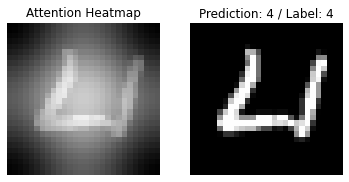

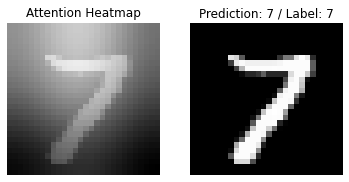

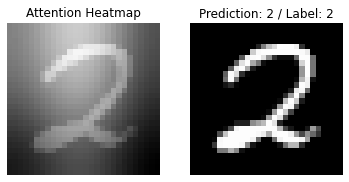

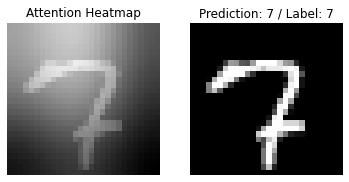

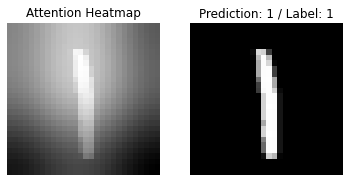

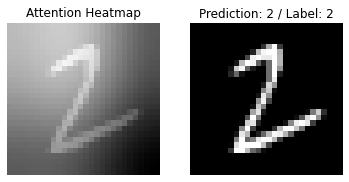

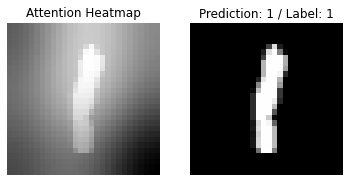

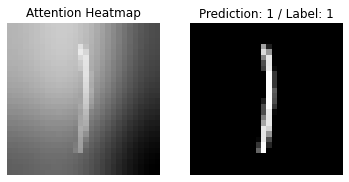

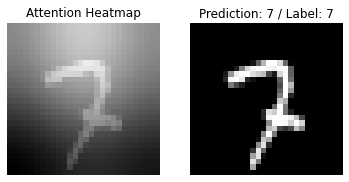

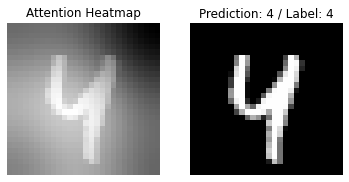

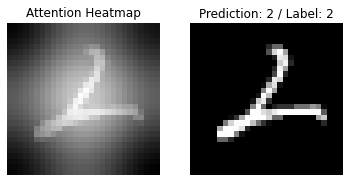

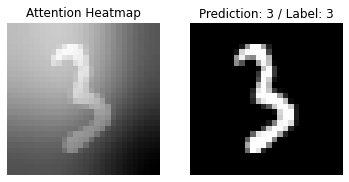

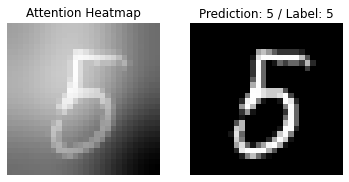

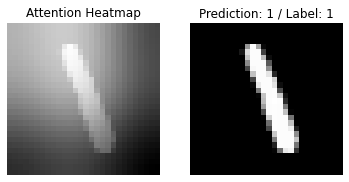

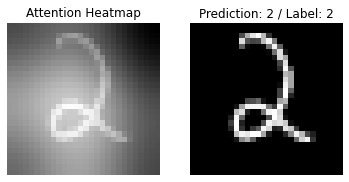

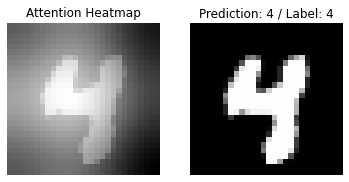

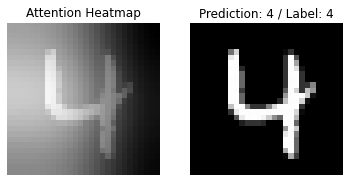

Sample Accuracy: 0.98


In [14]:
# Initialize fraction of test images and heatmap
test_fraction = np.zeros([10, img_size, img_size, 1])
heat_map = np.zeros([num_test_sample, img_size, img_size])

num_correct = 0.

# Test for Sampling data
for idx_sample in range(num_test_sample):
    
    # Get alpha(weight of fractions) and output for sample test data
    test_x_reshape = np.reshape(test_x, ([test_x.shape[0],img_size,img_size,1]))
    test_x_in = test_x_reshape[idx_sample,:,:,:]
    alpha_, output_ = sess.run([alpha, output],feed_dict = {x_image: [test_x_in], y_target: [test_y[idx_sample,:]]})
    alpha_size = int(np.sqrt(alpha_.shape[1]))
    alpha_reshape = np.reshape(alpha_, (alpha_size, alpha_size))
    alpha_resize = skimage.transform.pyramid_expand(alpha_reshape, upscale = 16, sigma=20)
    alpha_resize = cv2.resize(alpha_resize, dsize=(img_size,img_size), interpolation=cv2.INTER_LINEAR)
    
    # Make heatmap with alpha

    # Get labels for test samples
    y_test_pred = np.argmax(output_[:])
    y_test_true = np.argmax(test_y[idx_sample, :])
    
    # Draw subplot for each sample 
    f1, ax = plt.subplots(1,2)
    ax[0].imshow(test_x[idx_sample,:,:], cmap='gray')
    i = ax[0].imshow(alpha_resize,cmap="gray", alpha=0.8)
    ax[0].axis("off")
    ax[0].set_title('Attention Heatmap')
    
    ax[1].imshow(test_x[idx_sample,:,:], cmap='gray')
    ax[1].axis("off")
    ax[1].set_title('Prediction: ' + str(y_test_pred) + ' / ' + 'Label: ' + str(y_test_true))

    # Count correct
    if y_test_pred == y_test_true:
        num_correct += 1.

# Show results 
plt.show()
print('Sample Accuracy: ' + str(num_correct / num_test_sample))